This notebook loads the trained binary_resnet18.pt checkpoint and generates validation metrics and plots using shared utilities. It produces Accuracy, Recall, AUROC and saves ROC, PR, Confusion Matrix, Calibration, and Threshold Sweep plots. If a training history CSV exists, it also renders loss/accuracy curves.

In [6]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.utils.device_utils import get_device
from src.utils.models_utils import build_resnet18_binary, load_checkpoint
from src.utils.data_utils import make_loader
from src.utils.inference_utils import collect_outputs
from src.utils.metrics_utils import compute_core_metrics
from src.utils.plot_utils import (
    plot_roc_curve, plot_pr_curve, plot_confusion, plot_calibration, plot_threshold_sweep, plot_loss_acc_from_history
)

import matplotlib.pyplot as plt

In [7]:
def make_val_loader(batch_size=64):
    val_loader, label_names = make_loader("validation", batch_size=batch_size, shuffle=False, labeled=True)
    return val_loader, label_names

In [8]:
# -- Inline metrics display helper --
def display_metrics_inline(metrics):
    fig = plt.figure(figsize=(6,4))
    names = ["accuracy", "recall", "auroc"]
    vals = [metrics.get("accuracy", 0.0), metrics.get("recall", 0.0), metrics.get("auroc", 0.0)]
    plt.bar(names, vals)
    plt.ylim(0, 1)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.title("Validation Metrics")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()

In [9]:
# -- Evaluate checkpoint, show and save results --
def evaluate_checkpoint_and_plot(checkpoint_path="../artifacts/checkpoints/binary_resnet18.pt",
                                 history_csv="../artifacts/history_binary_resnet18.csv",
                                 plots_dir="../artifacts/plots",
                                 run_name="binary_resnet18_results",
                                 batch_size=64,
                                 use_tta=True):
    device = get_device()
    val_loader, label_names = make_val_loader(batch_size=batch_size)
    model = build_resnet18_binary(num_classes=2, use_pretrained=False)
    model = load_checkpoint(model, checkpoint_path, device)
    y_true, y_pred, y_prob = collect_outputs(model, val_loader, device, use_tta=use_tta)
    metrics = compute_core_metrics(y_true, y_pred, y_prob, pos_label_idx=label_names.index("malignant"))
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Recall:   {metrics['recall']:.4f}")
    print(f"AUROC:    {metrics['auroc']:.4f}")
    display_metrics_inline(metrics)
    os.makedirs(plots_dir, exist_ok=True)
    plot_roc_curve(y_true, y_prob, show=True, save_path=os.path.join(plots_dir, f"{run_name}_roc.png"))
    plot_pr_curve(y_true, y_prob, show=True, save_path=os.path.join(plots_dir, f"{run_name}_pr.png"))
    plot_confusion(y_true, y_pred, label_names, show=True, save_path=os.path.join(plots_dir, f"{run_name}_confusion.png"))
    plot_calibration(y_true, y_prob, show=True, save_path=os.path.join(plots_dir, f"{run_name}_calibration.png"))
    plot_threshold_sweep(y_true, y_prob, label_names, show=True, save_path=os.path.join(plots_dir, f"{run_name}_threshold_sweep.png"))
    plot_loss_acc_from_history(history_csv, show=True, out_prefix=os.path.join(plots_dir, run_name))
    return {"metrics": metrics, "label_names": label_names, "plots_dir": plots_dir}

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Accuracy: 0.8661
Recall:   0.9540
AUROC:    0.9562


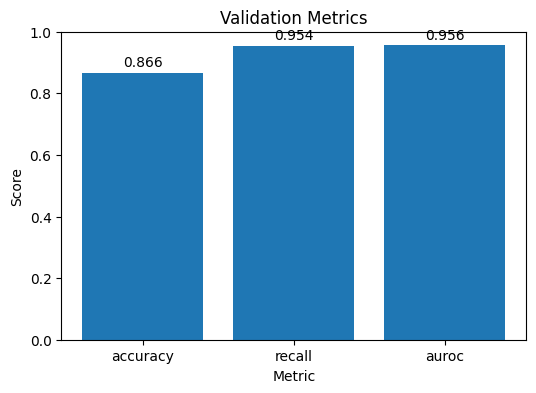

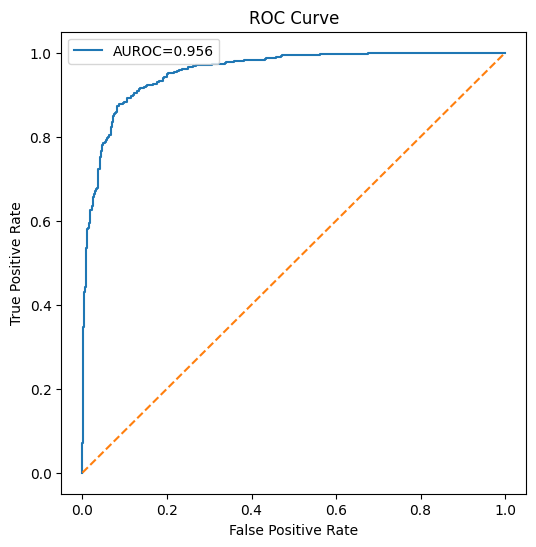

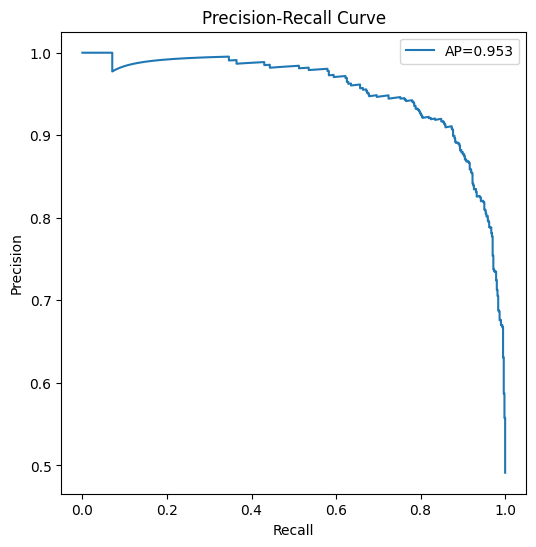

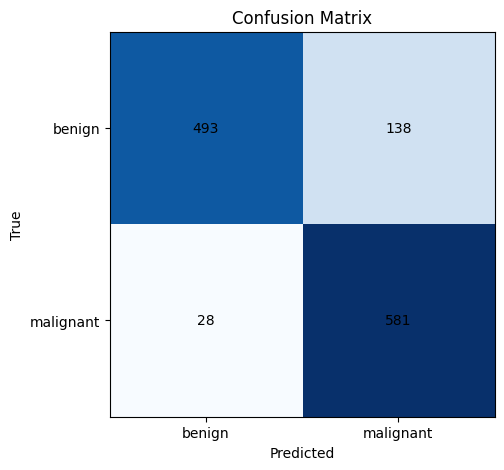

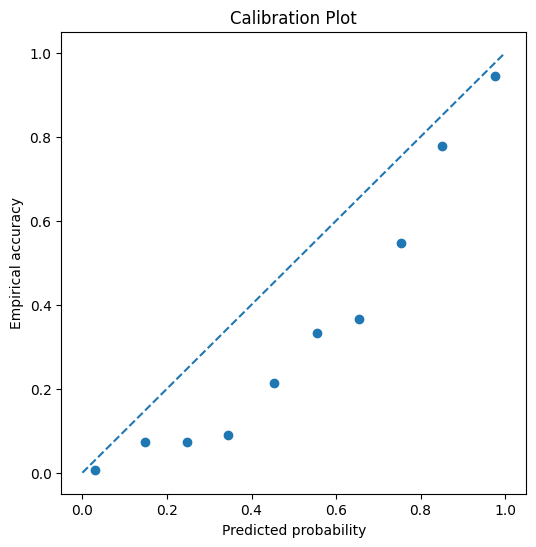

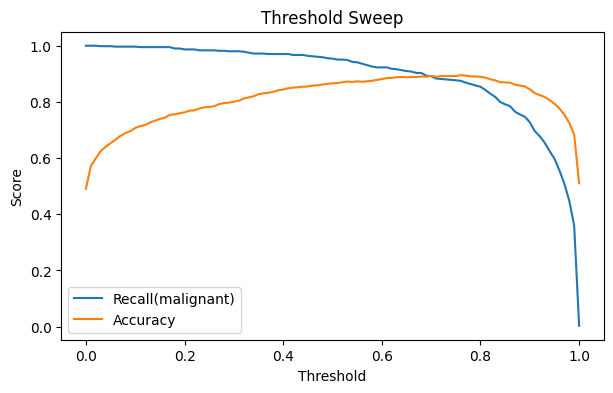

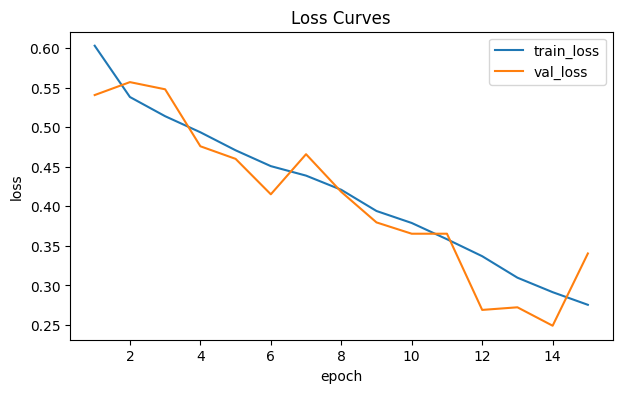

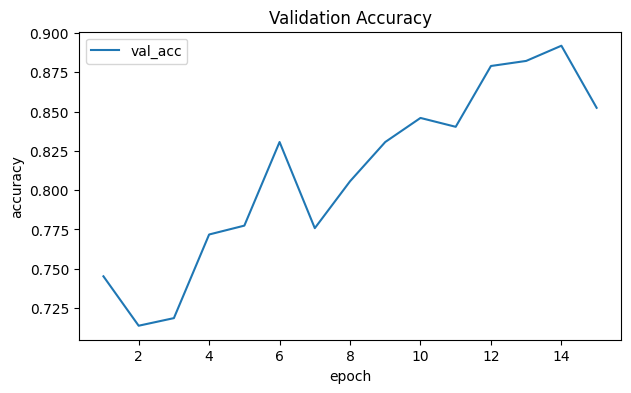

{'metrics': {'accuracy': 0.8661290322580645,
  'recall': 0.9540229885057471,
  'auroc': 0.9561776729927994},
 'label_names': ['benign', 'malignant'],
 'plots_dir': '../artifacts/plots'}

In [10]:
results = evaluate_checkpoint_and_plot()
results